In [23]:
import pandas as pd

In [24]:
import glob
import os

labels = ["baseline", "round-robin"]  # Lista schedulerów
branch_names = ["multiple-models-on-one-machine-support", "round-robin"]

files = []

for scheduler in branch_names:
    scheduler_files = glob.glob(f"../requests/requests_{scheduler}_*")
    
    newest_file = max(scheduler_files, key=os.path.getmtime)
    
    files.append(newest_file)
print(files)

['../requests/requests_multiple-models-on-one-machine-support_2024-06-11_18-01-41.csv', '../requests/requests_round-robin_2024-06-11_19-10-39.csv']


### LLMs

In [25]:
# labels = ["multiple-models-on-one-machine-support", "round-robin"]
# files = ['../requests/requests_multiple-models-on-one-machine-support_2024-06-11_18-01-41.csv', '../requests/requests_round-robin_2024-06-11_19-10-39.csv']

In [26]:
dfs = []
for f in files:
    df = pd.read_csv(f)
    df["arrival_time"] = pd.to_datetime(df["arrival_time"])
    df["start_time"] = pd.to_datetime(df["start_time"])
    df["finish_time"] = pd.to_datetime(df["finish_time"])
    df["response_time"] = (df["finish_time"] - df["arrival_time"]).dt.total_seconds()
    df["service_time"] = (df["finish_time"] - df["start_time"]).dt.total_seconds()
    start_time = df["arrival_time"].min()
    df["arrival_time"] = (df["arrival_time"] - start_time).dt.total_seconds()

    # df = df[df["arrival_time"] <= start_time + pd.Timedelta(minutes=20)]
    dfs.append(df)

In [27]:
def plot_cdfs(dfs, labels, column):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    for i, df in enumerate(dfs):
        data = df[column]
        data = np.sort(data)
        yvals = np.arange(len(data))/float(len(data))
        ax.plot(data, yvals, label=labels[i])
    ax.set_xscale('log')
    ax.set_xlabel(column)
    ax.set_ylabel("CDF")
    ax.legend()
    plt.show()

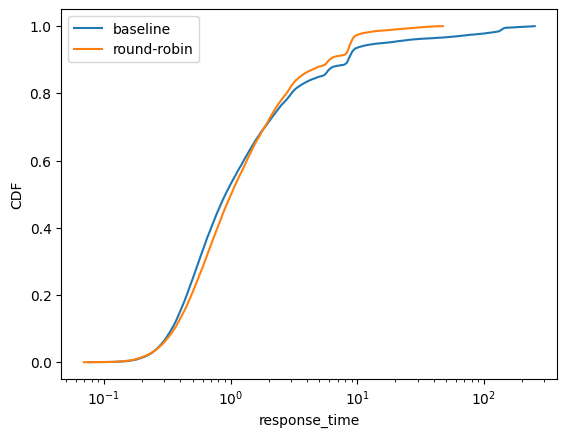

In [28]:
plot_cdfs(dfs, labels, "response_time")

In [29]:
dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46251 entries, 0 to 46250
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           46251 non-null  object        
 1   arrival_time                 46251 non-null  float64       
 2   model                        46251 non-null  object        
 3   expected_machine_type        46251 non-null  object        
 4   sla_time_seconds             46251 non-null  int64         
 5   continuous_batching_support  46251 non-null  bool          
 6   input_tokens                 46251 non-null  int64         
 7   output_tokens                46251 non-null  int64         
 8   start_time                   46251 non-null  datetime64[ns]
 9   finish_time                  46251 non-null  datetime64[ns]
 10  response_time                46251 non-null  float64       
 11  service_time                 46251 non-nu

In [30]:
def print_starved_requests(df):
    starved_requests = df[df["service_time"] > df['sla_time_seconds']]
    print(starved_requests)

In [31]:
print_starved_requests(dfs[0])

                                            id  arrival_time  \
3088    63357531732460164773112159177385473770       416.980   
3573   324838310673285832234200126125261795467       643.831   
4335   301020300876441155323152304687893979619      1060.609   
4846   297340645226813723950256794112857309578      1290.947   
5270   210504961037918079844560671213588438713      1463.229   
...                                        ...           ...   
45399  197597864329889769905307529453149013702      1721.616   
45576  220136900438030927301602022819338730166      1686.410   
45650   49310316526647887750284356373765947824      1688.929   
45773    4534179558916899707661764554142188103      1774.262   
45858  244765440090797522527923041187729559190      1761.179   

                                     model expected_machine_type  \
3088   1+1+1+c5.18xlarge+0.5-llama_7B-code           c5.18xlarge   
3573   1+1+1+c5.18xlarge+0.5-llama_7B-code           c5.18xlarge   
4335   1+1+1+c5.18xlarge+0.

In [32]:
for df in dfs:
    df["met_sla"] = df["response_time"]  <= df["sla_time_seconds"]

In [33]:
def plot_sla(dfs, labels):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    for i, df in enumerate(dfs):
        met_sla_percentage = df["met_sla"].sum() / len(df)
        ax.bar(labels[i], met_sla_percentage, label=labels[i])
    ax.set_ylabel("Percentage of requests meeting SLA")
    ax.set_xticklabels([])
    ax.legend(loc='lower left')
    plt.show()

In [34]:
def print_sla(dfs, labels):
    for i, df in enumerate(dfs):
        met_sla_percentage = df["met_sla"].sum() / len(df)
        print(f"{labels[i]}: {met_sla_percentage}")

In [35]:
print_sla(dfs, labels)

baseline: 0.9285637067306652
round-robin: 0.9676763745648743


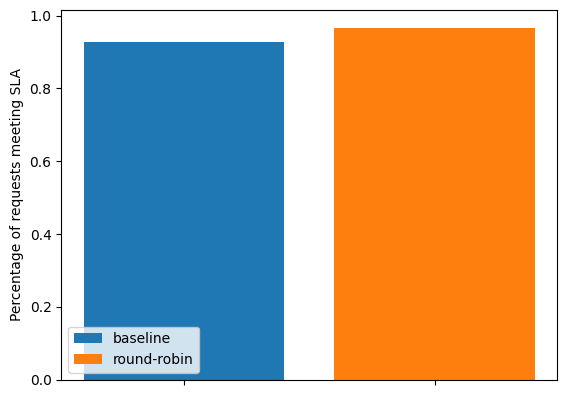

In [36]:
plot_sla(dfs, labels)

In [37]:
min([], default=0)

0

In [38]:
dfs[0].head()

,id,arrival_time,model,expected_machine_type,sla_time_seconds,continuous_batching_support,input_tokens,output_tokens,start_time,finish_time,response_time,service_time,met_sla
0,132644322393135686084574429640912327087,37.424,1+1+1+c5.18xlarge+0.5-llama_7B-conv,c5.18xlarge,10,False,1314,14,2024-06-11 17:35:03.065904,2024-06-11 17:35:03.189061,230.210208,0.123157,False
1,139455200212820871074772764470719910405,14.351,1+1+1+c5.18xlarge+0.5-llama_7B-conv,c5.18xlarge,10,False,383,110,2024-06-11 17:34:50.497535,2024-06-11 17:34:51.287048,241.381195,0.789513,False
2,206736275593488424890006477477784809840,54.446,1+1+1+c5.18xlarge+0.5-llama_7B-conv,c5.18xlarge,10,False,1057,520,2024-06-11 17:35:07.182455,2024-06-11 17:35:10.831061,220.830208,3.648606,False
3,98838832231642889213830716532933356877,18.785,1+1+1+c5.18xlarge+0.5-llama_7B-conv,c5.18xlarge,10,False,416,457,2024-06-11 17:34:52.665703,2024-06-11 17:34:55.859993,241.520140,3.194290,False
4,17543328326621052832344001587066403485,29.416,1+1+1+c5.18xlarge+0.5-llama_7B-conv,c5.18xlarge,10,False,404,71,2024-06-11 17:34:58.742056,2024-06-11 17:34:59.251317,234.280464,0.509261,False


In [39]:
# plot distribution (in time) of starved requests
def plot_starved_requests(dfs, labels):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    for i, df in enumerate(dfs):
        df_starved = df[df["met_sla"] == False]
        arrival_times = df_starved["arrival_time"]
        ax.hist(arrival_times, bins=20, label=labels[i])
        for rect in ax.patches:
            rect.set_alpha(0.5)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of starved requests")
    ax.legend()
    plt.show()


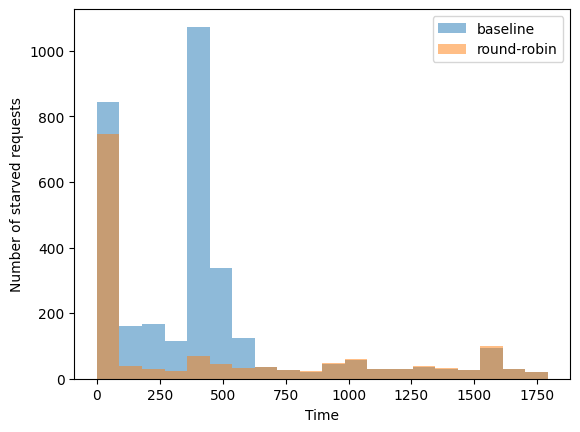

In [40]:
plot_starved_requests(dfs, labels)

In [41]:
def plot_starved_requests_models(df):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    for model, group in df.groupby('model'):
        group_starved = group[group["met_sla"] == False]
        arrival_times = group_starved["arrival_time"]
        ax.hist(arrival_times, bins=20, label=model)
        for rect in ax.patches:
            rect.set_alpha(0.5)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of starved requests")
    ax.legend()
    plt.show()

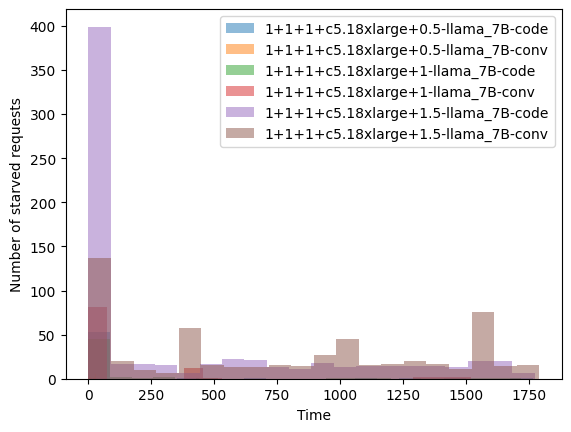

In [42]:
plot_starved_requests_models(dfs[1])

In [43]:
# count starved requests per model
def count_starved_requests_per_model(df):
    for model, group in df.groupby('model'):
        starved_requests = group[group["met_sla"] == False]
        print(f"{model}: {len(starved_requests)}")

In [44]:
count_starved_requests_per_model(dfs[2])

IndexError: list index out of range

In [ ]:
count_starved_requests_per_model(dfs[0])

1+1+1+c5.18xlarge+0.5-llama_7B-code: 1
1+1+1+c5.18xlarge+0.5-llama_7B-conv: 0
1+1+1+c5.18xlarge+1-llama_7B-code: 17
1+1+1+c5.18xlarge+1-llama_7B-conv: 0
1+1+1+c5.18xlarge+1.5-llama_7B-code: 78
1+1+1+c5.18xlarge+1.5-llama_7B-conv: 0
